In [28]:
import os
import numpy as np
import torch
from torch.optim import Adam
from torchvision import models
import matplotlib
# matplotlib.use('PS') 
%matplotlib notebook
import matplotlib.pyplot as plt
from misc_functions import preprocess_image, recreate_image, save_image

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 9)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.norm = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(7, 7)
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout2d(p=0.2)
#         self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,50)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x


## Visualize CNN Filters

In [42]:
class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        _ = nn.Sequential(*list(self.model.children())[:1])[0]
        _.register_forward_hook(hook_function)
        # self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 1)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model.children()):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                im = self.created_image[:,:,0]
#                 im = plt.imshow(self.created_image[:,:,0], cmap='gray')
                plt.imshow(im, cmap='gray', vmin=0, vmax=255)
                plt.savefig("./d{}.png".format(i))
#                 self.created_image.plot()
#                 save_image(self.created_image, im_path)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)


Iteration: 1 Loss: 0.39
Iteration: 2 Loss: 0.35
Iteration: 3 Loss: 0.31
Iteration: 4 Loss: 0.27
Iteration: 5 Loss: 0.23


<IPython.core.display.Javascript object>


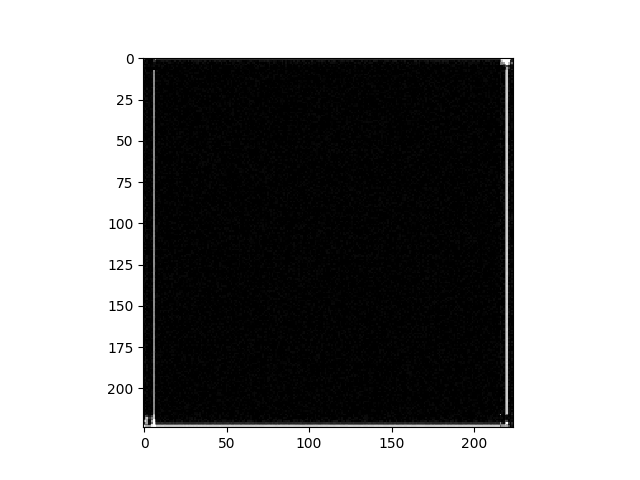

Iteration: 6 Loss: 0.19
Iteration: 7 Loss: 0.15
Iteration: 8 Loss: 0.11
Iteration: 9 Loss: 0.07
Iteration: 10 Loss: 0.03
Iteration: 11 Loss: -0.01
Iteration: 12 Loss: -0.05
Iteration: 13 Loss: -0.09
Iteration: 14 Loss: -0.12
Iteration: 15 Loss: -0.16
Iteration: 16 Loss: -0.20
Iteration: 17 Loss: -0.24
Iteration: 18 Loss: -0.28
Iteration: 19 Loss: -0.32
Iteration: 20 Loss: -0.35
Iteration: 21 Loss: -0.39
Iteration: 22 Loss: -0.43
Iteration: 23 Loss: -0.47
Iteration: 24 Loss: -0.50
Iteration: 25 Loss: -0.54
Iteration: 26 Loss: -0.58
Iteration: 27 Loss: -0.62
Iteration: 28 Loss: -0.65
Iteration: 29 Loss: -0.69
Iteration: 30 Loss: -0.72


In [43]:

cnn_layer = 1
filter_pos = 5
# Fully connected layer is not needed
pretrained_model = torch.load("../model_v0.pt")
# pretrained_model = models.vgg16(pretrained=True).features
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
# layer_vis.visualise_layer_without_hooks()
